In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


# 1. Génération de données synthétiques


In [3]:
def generate_cylinder_data(num_samples, img_size=64, max_rotation_angle=90):
    data = []
    for _ in range(num_samples):
        img = np.zeros((img_size, img_size))  # Fond noir
        radius = np.random.randint(img_size // 12, img_size // 4)
        height = np.random.randint(img_size // 10, img_size - radius * 2)
        x_center = img_size // 2  # Centre horizontal
        y_top = (img_size - height) // 2  # Centrer en hauteur
        #b_random = np.random.uniform(0.4, 0.6)  # Variation aléatoire du paramètre b
        b_random = .5

        # Dessin des bords parallèles
        for y in range(y_top, y_top + height):
            img[y, x_center - radius] = 1  # Bord gauche
            img[y, x_center + radius] = 1  # Bord droit

        # Dessin des ellipses supérieur et inférieur
        y, x = np.ogrid[:img_size, :img_size]
        ellipse_top = ((x - x_center)**2 / (radius**2)) + ((y - y_top)**2 / (b_random * radius)**2) <= 1
        ellipse_bottom = ((x - x_center)**2 / (radius**2)) + ((y - (y_top + height))**2 / (b_random * radius)**2) <= 1

        # Ajustement dynamique pour le contour
        contour_thickness = max(1, int(0.02 * radius))  # Épaisseur minimale de 1 pixel
        inner_top = (((x - x_center)**2 / (radius - contour_thickness)**2) +
                     ((y - y_top)**2 / ((b_random * radius) - contour_thickness)**2) <= 1)
        inner_bottom = (((x - x_center)**2 / (radius - contour_thickness)**2) +
                        ((y - (y_top + height))**2 / ((b_random * radius) - contour_thickness)**2) <= 1)

        # Contours des ellipses
        top_edge = ellipse_top & ~inner_top
        bottom_edge = ellipse_bottom & ~inner_bottom

        # Masquer l'arrière de l'ellipse inférieure
        bottom_edge &= (y > (y_top + height))

        # Ajouter les contours au cylindre
        img[top_edge] = 1
        img[bottom_edge] = 1

        # Ajouter une rotation aléatoire
        rotation_angle = np.random.uniform(-max_rotation_angle, max_rotation_angle)
        img_rotated = rotate(img, angle=rotation_angle, reshape=False, order=1, mode='constant', cval=0)

        # Ajouter l'image générée à la liste
        data.append(np.expand_dims(img_rotated, axis=-1))  # Ajout de la dimension canal

    return np.array(data)



## Génération des données


In [8]:
num_samples = 5000
img_size = 128
data = generate_cylinder_data(num_samples, img_size, max_rotation_angle= 90)
data = data.astype('float32')

display(data.shape)

# Normalisation pour BCE
data = data/1.0

(5000, 128, 128, 1)

## Visualisation des données synthétiques


In [6]:
def visualize_original_data(data, n_images=5):
    cols = 5  # Nombre maximum de colonnes
    rows = (n_images + cols - 1) // cols  # Calcul du nombre de lignes nécessaires
    plt.figure(figsize=(cols * 2, rows * 2))  # Ajuster la taille de la figure

    for i in range(n_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(data[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


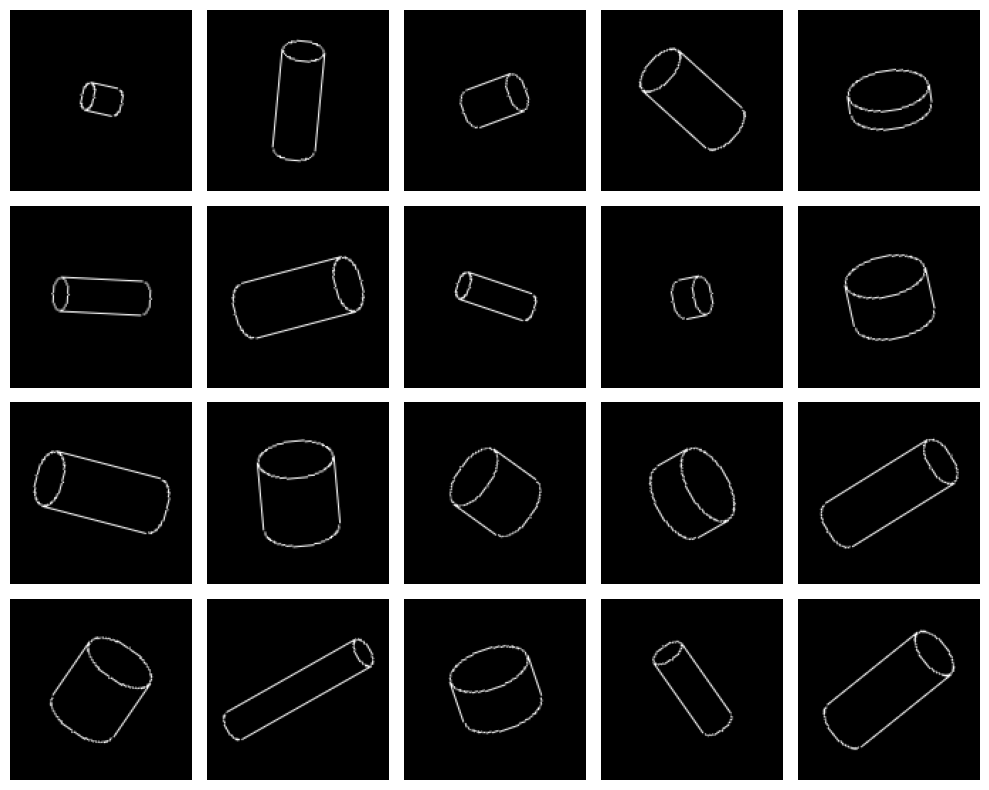

In [9]:
# Visualiser quelques cylindres
visualize_original_data(data, n_images = 20)

# 2. Définition du VAE


In [10]:
latent_dim = 3 # Taille de l'espace latent
beta = .05

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Passe avant
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            # Calcul des pertes

            # mse = tf.keras.losses.MeanSquaredError()
            # reconstruction_loss = tf.reduce_mean(
            #         mse(data, reconstructed)
            #)

            # Calcul des pertes ssim
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(
                    1.0 - tf.image.ssim(data, reconstructed, max_val=1.0)
                )
            )


            # Calcul des pertes BCE
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed), axis=(1, 2)
                )
            )

            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = reconstruction_loss + beta * kl_loss

        # Calcul des gradients et mise à jour des poids
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = layers.Input(shape=(img_size, img_size, 1))
x = layers.Conv2D(16, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

z = Sampling()([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(shape_before_flattening), activation='relu')(latent_inputs)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)  # 128x128

outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Modèles
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])

# Instanciation du VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

In [11]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 16)     │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 3)              │         49,155 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 3)              │         49,155 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 3)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 121,606 (475.02 KB)

 Trainable params: 121,606 (475.02 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 16)        │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 1)         │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,561 (869.38 KB)

 Trainable params: 222,561 (869.38 KB)

 Non-trainable params: 0 (0.00 B)

# 3. Entraînement


In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Définir les callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)


In [13]:
vae.fit(data, data,
        epochs=100, batch_size=100)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - kl_loss: 280.1692 - loss: 3313.9294 - reconstruction_loss: 3299.9209
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - kl_loss: 45.0590 - loss: 1068.2821 - reconstruction_loss: 1066.0292
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - kl_loss: 44.1460 - loss: 1051.9620 - reconstruction_loss: 1049.7548
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - kl_loss: 38.9172 - loss: 1046.5864 - reconstruction_loss: 1044.6406
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - kl_loss: 32.8027 - loss: 1042.7362 - reconstruction_loss: 1041.0961
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - kl_loss: 28.5426 - loss: 1037.6917 - reconstruction_loss: 1036.2645
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - kl_loss: 25.5399 - loss: 1025.1545 - reconstruction_loss: 1023.8776
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - kl_loss: 29.3370 - loss: 986.6323 - reconstruction_loss: 985.1654
Epoch 9/100
50/50 ━━━━━

# 5. Génération d'images


In [14]:
def generate_images(decoder, n_images=10):
    random_latent_vectors = np.random.normal(size=(n_images, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    # Définir les dimensions de la grille
    cols = 5  # Nombre maximum de colonnes
    rows = (n_images + cols - 1) // cols  # Calculer le nombre de lignes nécessaires
    plt.figure(figsize=(cols * 2, rows * 2))  # Ajuster la taille de la figure

    for i in range(n_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()  # Ajuster les espaces entre les sous-graphes
    plt.show()


In [15]:
decode1 = decoder #latent_dim = 2

In [ ]:
decode2 = decoder #latent_dim = 3 et perte ssim

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


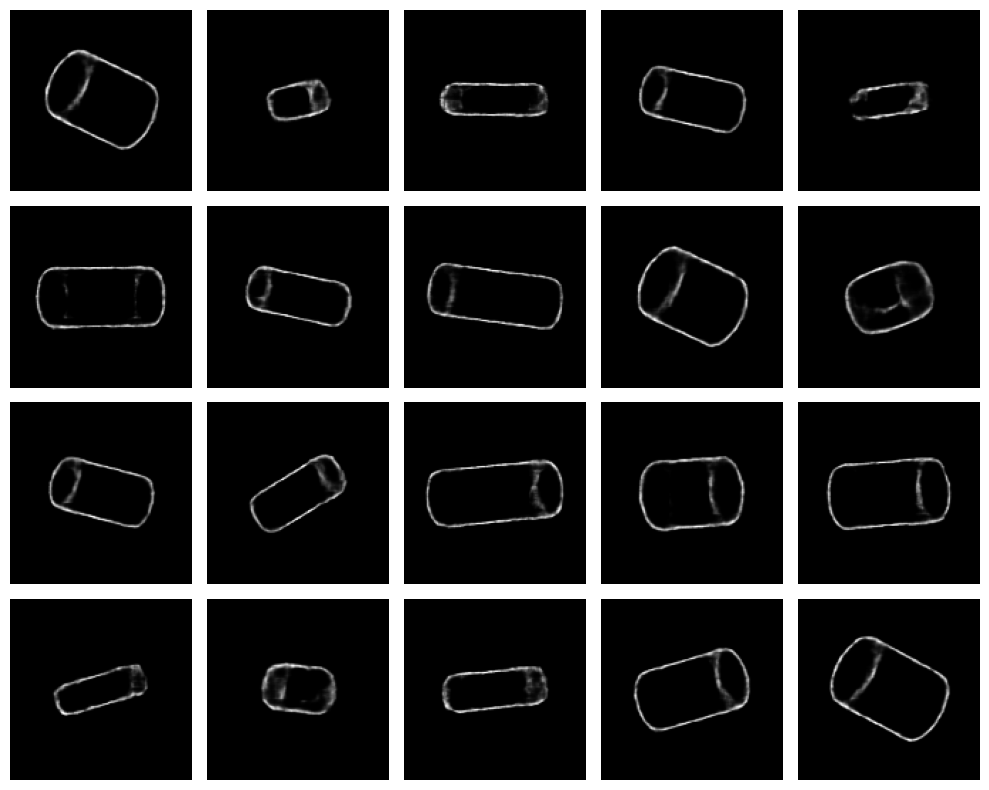

In [16]:
#latent_dim = 3
generate_images(decoder, n_images=20)

In [ ]:
#latent_dim = 4
generate_images(decoder, n_images=10)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


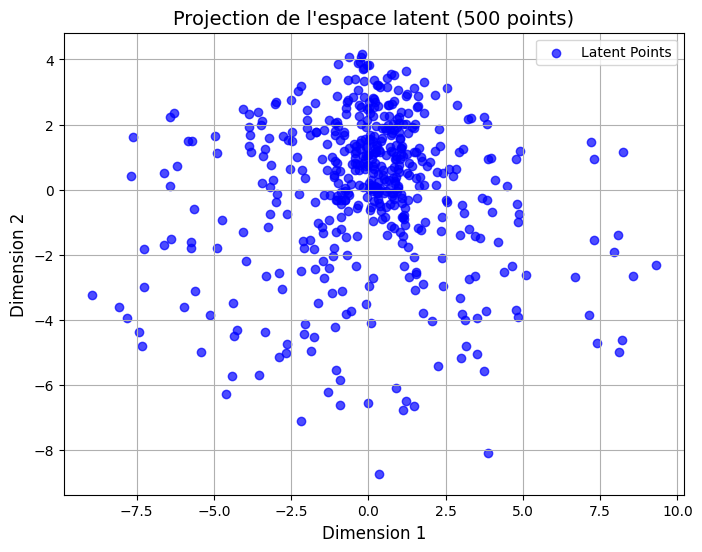

In [17]:
from sklearn.decomposition import PCA

# Étape 1 : Échantillonner 100 cylindres aléatoires
num = 500
indices = np.random.choice(data.shape[0], num, replace=False)
sampled_data = data[indices]

# Étape 2 : Obtenir les représentations latentes
z_mean, z_log_var, z_latent = vae.encoder.predict(sampled_data)

# Étape 3 : Réduire à 2 dimensions avec PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(z_latent)


# Étape 4 : Visualiser l'espace latent
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.7, label='Latent Points')
plt.title(f"Projection de l'espace latent ({num} points)", fontsize=14)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
z_latent.argmax(axis=0)

array([112, 451])

In [21]:
extreme_imagee = decoder.predict(tf.tensor(z_latent[112]))

AttributeError: module 'tensorflow' has no attribute 'tensor'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


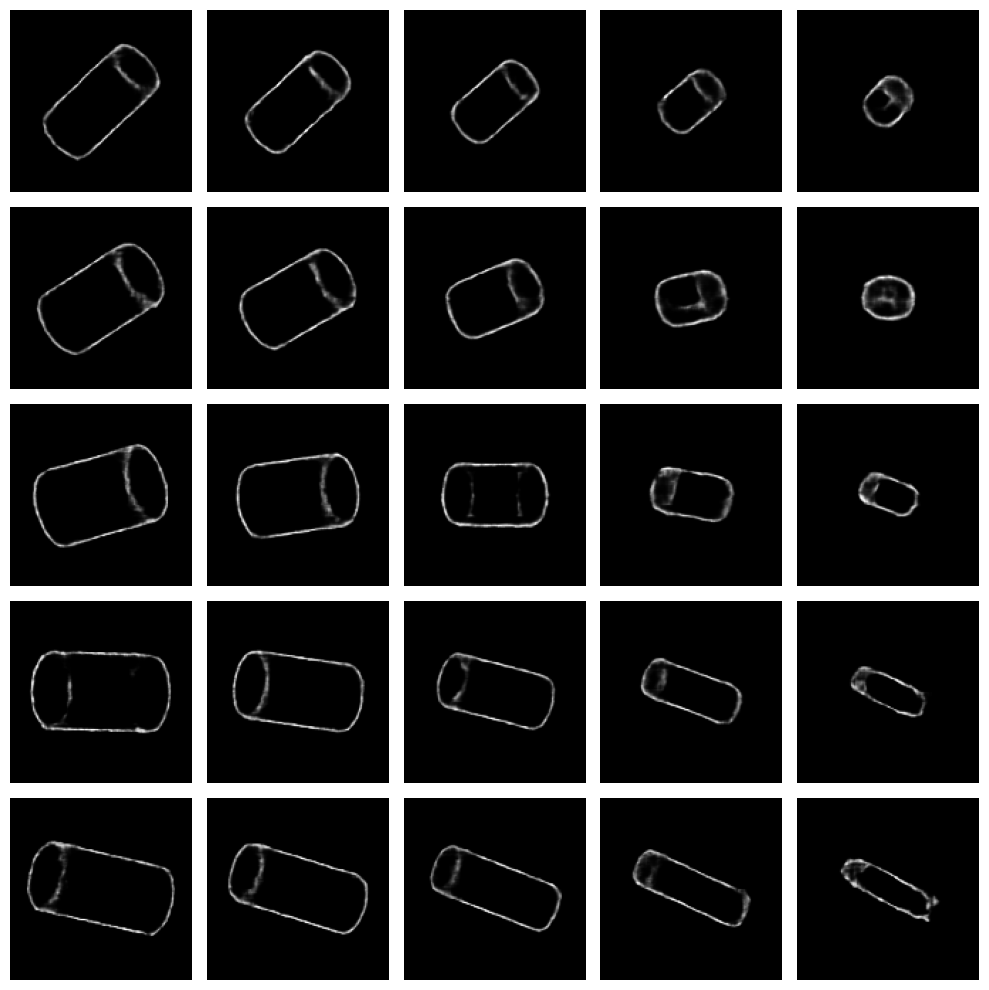

In [18]:
num_points = 5

# Points fixes pour toutes les dimensions sauf deux
fixed_latent = np.zeros((num_points**2, latent_dim))

# Variation des deux premières dimensions
grid_x = np.linspace(-3, 3, num=num_points)
grid_y = np.linspace(-3, 3, num=num_points)

for i, x in enumerate(grid_x):
    for j, y in enumerate(grid_y):
        fixed_latent[i * num_points + j, 0] = x  # Variation de la 1ère dimension
        fixed_latent[i * num_points + j, 1] = y  # Variation de la 2ème dimension

# Génération d'images
generated_images = decoder.predict(fixed_latent)

# Visualisation
plt.figure(figsize=(num_points * 2, num_points * 2))
for i, image in enumerate(generated_images):
    ax = plt.subplot(num_points, num_points, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


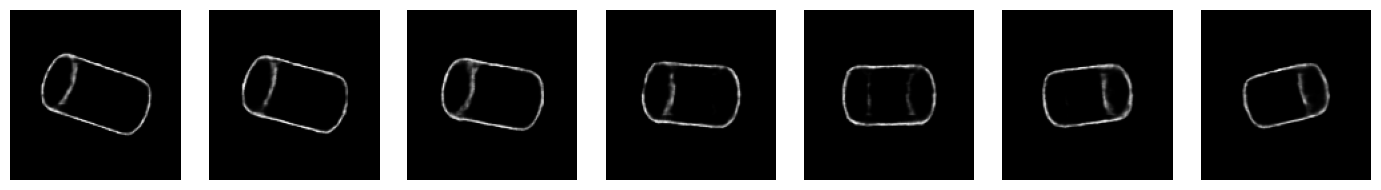

In [22]:
num = 7
# Points dans l'espace latent
z1 = np.random.normal(size=(latent_dim,))
z2 = np.random.normal(size=(latent_dim,))

# Interpolation linéaire entre z1 et z2
interpolations = np.linspace(0, 1, num=num)[:, None] * z1 + (1 - np.linspace(0, 1, num=num)[:, None]) * z2

# Génération et affichage
generated_images = decoder.predict(interpolations)

plt.figure(figsize=(20, 2))
for i, image in enumerate(generated_images):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
